In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Conv2d, ConvTranspose2d
from torch.utils import data
from torch import optim

from tqdm import trange, tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import rbf_kernel as rbf

from torch.distributions import MultivariateNormal

device = "cuda"

In [3]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

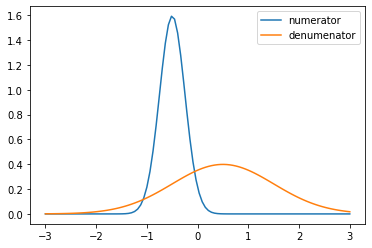

In [ ]:
# distributions

In [4]:
class KMM(nn.Module):
  def __init__(self, hd=128):
    super().__init__()
    self.r = nn.Sequential(nn.Linear(1, hd), 
                            nn.ReLU(),
                            nn.Linear(hd, hd), 
                            nn.ReLU(),
                            nn.Linear(hd, 1),
                            nn.Softplus())
    
  def kernel(self, vec1, vec2):
      return torch.tensor(rbf(vec1.cpu(), vec2.cpu(), gamma=10)).to(device)
   
  def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=100):
     
      optimizer = optim.Adam(self.r.parameters(), lr=lr)

      for epoch in tqdm(range(num_epochs)):
            
            for (batch_nu, batch_de) in zip(data_nu, data_de):    

                batch_nu = batch_nu.reshape(-1, 1).float().to(device)
                batch_de = batch_de.reshape(-1, 1).float().to(device)

                ones_nu = torch.ones_like(batch_nu, requires_grad=False)

                r_de = self.r(batch_de)
                k_de = self.kernel(batch_de, batch_de)
                k_nu = self.kernel(batch_de, batch_nu)

                loss = (r_de.T.matmul(k_de).matmul(r_de) - 2 * r_de.T.matmul(k_nu).matmul(ones_nu)).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  
  kmm = KMM().to(device)

  dataloader_nu = data.DataLoader(data_nu, batch_size=512, shuffle=True)
  dataloader_de = data.DataLoader(data_de, batch_size=512, shuffle=True)
  
  kmm.fit(dataloader_nu, dataloader_de)

  # you need to calculate density ratio on x and return it
  x = np.linspace(-2., 2, num=100)
  x_pred = kmm.r(torch.tensor(x).reshape(-1, 1).float().to(device)).detach().cpu().numpy()

  return x_pred

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


<Figure size 432x288 with 0 Axes>

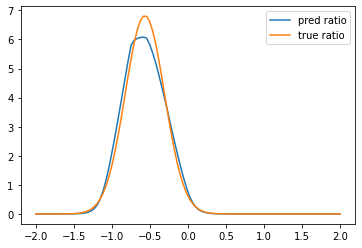

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [4]:
class Dataset:
  def __init__(self):
      self.data = None
  
  def get_dataloader(self, data: np.ndarray):
      self.data = torch.tensor(data).float()
      self._transpose_data()
    
      return torch.utils.data.DataLoader(self.data,
                                          pin_memory=True,
                                          drop_last=False,
                                          num_workers=4,
                                          batch_size=512)

  def _transpose_data(self):
      self.data = self.data.permute(0, 3, 1, 2)

In [5]:
config = {"encoder":
          {"n_encoder_layers": 3,
           "out_channels": 32,
           "flatten_dim": 16,
           "lattent_dim": 128},
         "decoder":
          {"n_decoder_layers": 3,
           "in_channels": 128,
           "in_img_size": 4,
           "lattent_dim": 128},
         "classifier": 
          {"n_encoder_layers": 3,
           "out_channels": 32,
           "flatten_dim": 16,
           "lattent_dim": 128},
          "vae":
          {"grad_clip": 1,
           "epochs": 15,
           "lr": 1e-3,
           "verbose": 5, 
           "lattent_dim": 128, 
           "n_samples": 100}
        }

In [67]:
class Encoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)

        relu = torch.nn.ReLU()
        model = [Conv2d(1, self.out_channels, 3, 1, 1)]
        in_channels = self.out_channels

        for _ in range(self.n_encoder_layers):
            if in_channels != 128:
                out_channels = in_channels * 2
            model.extend([relu, Conv2d(in_channels, out_channels, 3, 2, 1)])
            in_channels = out_channels

        self.model = torch.nn.Sequential(*model)
        self.linear = torch.nn.Linear(self.flatten_dim * 128, self.lattent_dim)

    def forward(self, x):
        output = self.model(x)  
        output = output.reshape(output.shape[0], -1)
        output = self.linear(output)
        print(output.shape)
        return output 

In [68]:
encoder = Encoder(**config["encoder"])
encoder

Encoder(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (linear): Linear(in_features=2048, out_features=128, bias=True)
)

In [81]:
class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)

        self.linear = torch.nn.Linear(self.lattent_dim, 128 * 4 * 4)
        
        relu = torch.nn.ReLU()
        out_channels = self.in_channels
        in_channels = self.in_channels
        model = []
        for _ in range(self.n_decoder_layers):
          model.extend([ConvTranspose2d(in_channels, out_channels, 4, 2, 1), relu])
          in_channels = out_channels
          out_channels = out_channels // 2

        self.model = torch.nn.Sequential(*model)
        self.conv_layer = Conv2d(in_channels, 1, 3, 1, 1)

    def forward(self, x):
        output = self.model(x)
        output = self.conv_layer(output)
        output = F.relu(self.linear(output))
        return output

In [77]:
128 * 16

2048

In [71]:
decoder = Decoder(**config["decoder"])
decoder

Decoder(
  (linear): Linear(in_features=128, out_features=2048, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (conv_layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [72]:
class Classifier(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)

        relu = torch.nn.ReLU()
        model = [Conv2d(1, self.out_channels, 3, 1, 1)]
        in_channels = self.out_channels

        for _ in range(self.n_encoder_layers):
            if in_channels != 128:
                out_channels = in_channels * 2
            model.extend([relu, Conv2d(in_channels, out_channels, 3, 2, 1)])
            in_channels = out_channels

        self.model = torch.nn.Sequential(*model)

        linears = [torch.nn.Linear(self.flatten_dim * 128, self.lattent_dim)]
        linears.extend([relu, torch.nn.Linear(self.lattent_dim, self.lattent_dim)])
        linears.extend([relu, torch.nn.Linear(self.lattent_dim, 1)])

        self.linears = torch.nn.Sequential(*linears)

    def forward(self, x, z):
        output = self.model(x)  
        output = output.reshape(output.shape[0], -1)
        output = self.linears(torch.cat((output, z), dim=1))
        return output 

In [73]:
classifier = Classifier(**config["classifier"])
classifier

Classifier(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (linears): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [74]:
class AVB:
  def __init__(self):
      super().__init__()
      for key, value in config["vae"].items():
        setattr(self, key, value)
      self.encoder = Encoder(**config["encoder"]).to(device)
      self.decoder = Decoder(**config["decoder"]).to(device)
      self.classifier = Classifier(**config["classifier"]).to(device)

      self.elbo_optimizer = torch.optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()),
                                             lr=self.lr)
      self.clas_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=self.lr)
      self.distribution = MultivariateNormal(torch.zeros(self.lattent_dim, device=device), 
                                             torch.eye(self.lattent_dim, device=device))


  def loss(self, x):
      x = 2 * x - 1
      z = self.encoder(x)
      x_hat = self.decoder(z)
      cl = self.classifier(x, z)

      rc_loss = F.mse_loss(x, x_hat, reduction='none').view(x.shape[0], -1).sum(1)
      elbo_loss = (rc_loss + cl).mean()

      s = self.distribution.sample(x.shape[0])

      cl_real = torch.sigmoid(self.classifier(x, z.detach()))
      cl_loss_real = F.binary_cross_entropy(cl_real, torch.ones_like(cl_real))

      cl_fake = torch.sigmoid(self.classifier(x, s))
      cl_loss_fake = F.binary_cross_entropy(cl_fake, torch.ones_like(cl_fake))

      classifier_loss = (cl_loss_real + cl_loss_fake).mean()

      return defaultdict(el_loss=elbo_loss, cl_loss=classifier_loss) 


  def sample(self, n):
      with torch.no_grad():
          z = self.distribution.sample((self.lattent_dim))
          samples = torch.clamp(self.decoder(z), -1, 1)
          samples = samples.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
      return samples * 255.


  def train_loop(self, train_loader):
      self.encoder.train()
      self.decoder.train()
      self.classifier.train()

      train_losses = defaultdict(lambda: [])
      for epoch in trange(self.epochs):
        epoch_train_losses = defaultdict(lambda: [])
        for x in train_loader:
          x = x.to(device)
          torch.cuda.empty_cache()
          
          losses = self.loss(x)
          self.elbo_optimizer.zero_grad()
          losses['el_loss'].backward()
          self.elbo_optimizer.step()

          self.clas_optimizer.zero_grad()
          losses['cl_loss'].backward()
          self.clas_optimizer.backward()

          for k in losses.keys():
            epoch_train_losses[k].append(losses[k].item())
          

        for k in epoch_train_losses.keys():
          train_losses[k].append(np.mean(epoch_train_losses[k]))

      train_losses = np.stack((train_losses['el_loss'], train_losses['cl_loss']), axis=1) 
      samples = self.sample(self.n_samples)
      
      return train_losses, samples

In [75]:
def q2(train_data, test_data):
  """
  train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
   Returns
  - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
  - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
  - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
  """
  # your code goes here
  dataset = Dataset()

  train_loader = dataset.get_dataloader(train_data)
  model = AVB()
  train_losses, samples = model.train_loop(train_loader)
  return train_losses["el_loss"], train_losses["cl_loss"], samples

In [82]:
q2_results(q2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([512, 128])


  0%|          | 0/15 [00:01<?, ?it/s]


RuntimeError: ignored